In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import json
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Z TS
$$Z_{t} = Ln\left (\frac{S_{t}}{\widehat{S_{t}}}\right )$$

In [4]:
#Load residuals as z and set index as datetime
z_df = pd.read_json('inputs_json/residuals_band_lgbm.json', 
                     orient='index')

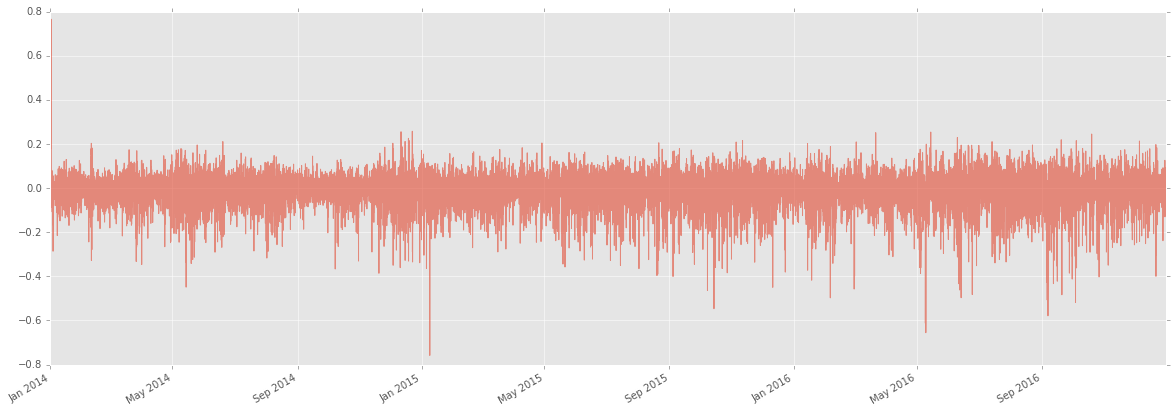

In [5]:
#Plot Z TS
fig, ax0 = plt.subplots(1,1, figsize=(20,7))
z_df['residuals'].plot(ax=ax0, alpha=0.6);

### Dick-Fuller test on stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [8]:
perform_stationarity_test(z_df['residuals'])

Results of the Dickey-Fuller Test:
Test Statistic                  -31.517522
p-value                           0.000000
#Lags used                       24.000000
Number of observation used    26276.000000
Critical value (5%)              -2.861650
Critical value (10%)             -2.566829
Critical value (1%)              -3.430599
dtype: float64


### ACF and PACF

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [10]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

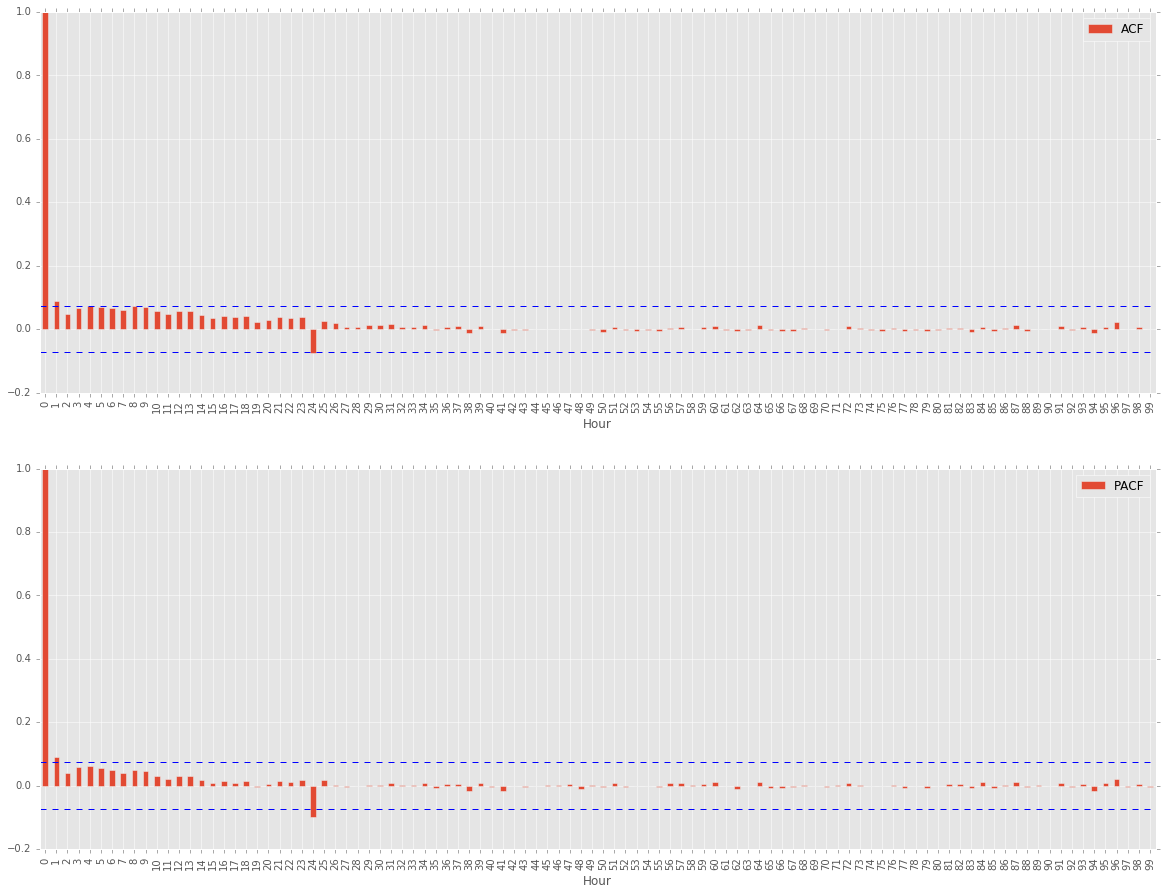

In [11]:
#ACF and PACF suggest an ARMA model with p = 24 and q = 24, since Hour 0 to 23 cannot be used
computer_acf_pacf(z_df['residuals'], 720, 720)

### ARIMA model, p=24

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [16]:
ar = np.zeros(24)

In [18]:
ar[-1] = 1

In [19]:
ar

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [20]:
model = SARIMAX(endog=z_df['residuals'].values, order=(ar,0,0))

In [21]:
%%time
results = model.fit(maxiter=400, disp=-1)

Wall time: 11.4 s


In [22]:
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                26301
Model:             SARIMAX((24,), 0, 0)   Log Likelihood               32551.572
Date:                  Sun, 19 Mar 2017   AIC                         -65099.144
Time:                          11:29:47   BIC                         -65082.789
Sample:                               0   HQIC                        -65093.863
                                - 26301                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L24        -0.0611      0.005    -11.939      0.000      -0.071      -0.051
sigma2         0.0049   1.84e-05    268.171      0.000       0.005       0.005
Ljung-Box (Q):                     2

In [23]:
def compute_SARIMAX_model(timeseries, p, d, q):
    """
    Computes the SARIMAX model for a given timeseries with order p, d, q
    """
    model = SARIMAX(endog=timeseries.values, order=(p,d,q))
    fitted_model = model.fit(disp=-1, maxiter=400)
    return fitted_model

In [24]:
def check_cv_fold(timeseries, train_index, test_index, p, d, q):
    """
    Computes the 24-hour following error for an specific CV fold 
    """
    model = compute_SARIMAX_model(timeseries.iloc[train_index], p, d, q)
    y_pred = model.forecast(steps=24)
    y_true = timeseries.iloc[test_index].values[:24]
    error = mean_squared_error(y_true, y_pred)
    train_residuals = np.mean(model.resid**2)
    print('train length: %d, train MSE %.4f, test MSE %.4f' %(len(train_index), train_residuals, error))
    return train_residuals, error

In [25]:
%%time
tscv = TimeSeriesSplit(n_splits=10)
train_error = list()
test_error = list()
for train_index, test_index in tscv.split(z_df['residuals'].values):
    tr_error, ts_error = check_cv_fold(z_df['residuals'], train_index, test_index, ar, 0, 0)
    train_error.append(tr_error)
    test_error.append(ts_error)
print('CV Train MSE: %.4f, Test MSE: %.4f' %(np.mean(train_error), np.mean(test_error)))

train length: 2391, train MSE 0.0052, test MSE 0.0023
train length: 4782, train MSE 0.0047, test MSE 0.0072
train length: 7173, train MSE 0.0039, test MSE 0.0012
train length: 9564, train MSE 0.0041, test MSE 0.0033
train length: 11955, train MSE 0.0039, test MSE 0.0017
train length: 14346, train MSE 0.0040, test MSE 0.0093
train length: 16737, train MSE 0.0042, test MSE 0.0075
train length: 19128, train MSE 0.0043, test MSE 0.0019
train length: 21519, train MSE 0.0045, test MSE 0.0073
train length: 23910, train MSE 0.0049, test MSE 0.0061
CV Train MSE: 0.0044, Test MSE: 0.0048
Wall time: 1min 3s


In [26]:
fitted_model = compute_SARIMAX_model(z_df['residuals'], ar, 0, 0)

In [27]:
fitted_model.arparams

array([-0.06105921,  0.00492548])

In [28]:
fitted_model.resid.std()

0.069620214753391543

$$Z_{t} = \alpha_{24} \cdot Z_{t-24} + \epsilon _{t}$$

$$\epsilon _{t} \sim N(0, \sigma _{x} ^{2})$$

In [31]:
#Export armaparams into a json
arima_parameters ={
    'ar':fitted_model.arparams.tolist()[0],
    'std':fitted_model.resid.std()
}

with open('inputs_json/arima_band_parameters.json', 'w') as f:
     json.dump(arima_parameters, f)